<a href="https://colab.research.google.com/github/edegp/katakana/blob/main/VGG(4)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
ROOT_PATH = '/content/drive/My Drive/Colab Notebooks/'
sys.path.append(ROOT_PATH)
import common

Mounted at /content/drive


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
from common.loss import mean_squared_error
from common.multi_layer_net_extend import MultiLayerNetExtend
from collections import OrderedDict
from common.layers import Convolution,MaxPooling, ReLU, Affine, LogSoftmaxWithLoss,BatchNormalization,Dropout
from common.optimizer import RMSProp,Adadelta,Adam
from common.pruning import *

In [ ]:
!pip install optuna
import optuna

     |████████████████████████████████| 308 kB 5.3 MB/s 
     |████████████████████████████████| 81 kB 7.6 MB/s 
     |████████████████████████████████| 210 kB 53.3 MB/s 
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 150 kB 50.8 MB/s 
     |████████████████████████████████| 113 kB 55.7 MB/s 
     |████████████████████████████████| 49 kB 4.8 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=ae998ee4ee29b6febf78876867cb64478c06ebbb6693c62969b954fcf1b4efe7
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
def he(n):
    """
    Heの初期値を利用するための関数
    返り値は、見かけの標準偏差
    """    
    return np.sqrt(2/n)

In [ ]:
def xavier(n1, n2):
    """
    Xavierの初期値を利用するための関数
    返り値は、見かけの標準偏差
    """
    return np.sqrt(2/(n1+n2))   

In [ ]:
def images_gen(data,label,datagen,num):
    datas = [];
    labels = [];
    data = data.transpose(0,2,3,1)
    for data,label in zip(data,label):
        data = data.reshape((1,) + data.shape)
        batch_list=[]
        i = 0
        g = datagen.flow(data, batch_size=1)
        for i in range(num):
          batchs = g.next()
          batchs=batchs.reshape((28, 28, 1)).transpose(2,0,1)
          datas.append(batchs)
          labels.append(label)
    train_data=np.array(datas)
    train_label=np.array(labels)
    for l in [train_data, train_label]:
      np.random.seed(1)
      np.random.shuffle(l) 
    return train_data,train_label            


In [ ]:
def create_img(X_train,y_train,num):
      # ImageDataGeneratorのオブジェクト生成
    datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.3,
            shear_range=15
            )
    X_train,y_train=images_gen(X_train,y_train,datagen,num)
    print(X_train.shape)
    print(y_train.shape)

    x = X_train
    t = y_train

    x = x.reshape(-1,1,28,28) # 配列形式の変形

    return x,t


In [ ]:
class GlobalAveragePooling2D:
    def __init__(self, GlobalPooling2D='channels_last'):
        self.data_format = GlobalPooling2D

    def forward(self, x):
        self.x = x
        out = x.mean(axis= (2, 3))
        return out

    def backward(self, dout):
        xs = self.x.shape
        n = xs[2] * xs[3]
        dx = np.empty((xs))
        for i in range(xs[0]):
          dx[i]=np.tile(dout[i] / n,(n)).reshape([xs[1],xs[2],xs[3]],order='F')
        return dx

In [ ]:
data = np.load("drive/My Drive/Colab Notebooks/test/train_data.npy")  # パスは適宜変更すること
label = np.load("drive/My Drive/Colab Notebooks/test/train_label.npy")  # パスは適宜変更すること
# 正規化
data = (data - data.min()) / data.max()
data = data.astype('float32')
X_train, X_test,y_train,y_test = train_test_split(data,label, test_size=0.1, random_state=12)

In [ ]:
class SimpleConvNet:
    def __init__(self, input_dim=(1, 28, 28),
                 param=[[32,3,0,1],[64,3,0,1]],
                 pool_param=[[2,0,2],[2,0,2]],
                output_size=15, 
                 weight_decay_lambda=1e-5,
                 ):
        self.weight_decay_lambda = weight_decay_lambda

        self.params = {}
        #一層目
        self.params['W1'] = he(input_dim[0]) * np.random.randn(param[0][0], input_dim[0], param[0][1], param[0][1]) 
        self.params['b1'] = np.zeros(param[0][0])
        self.params['gamma2'] = np.ones(param[0][0])
        self.params['beta2'] = np.zeros(param[0][0])

        # 二層目
        self.params['W2'] = he(param[0][0]) * np.random.randn(param[0][0], param[0][0], param[0][1], param[0][1]) 
        self.params['b2'] = np.zeros(param[0][0])
        
        #三層目
        self.params['W3'] = he(param[0][0])  * np.random.randn(param[1][0], param[0][0], param[1][1], param[1][1]) 
        self.params['b3'] = np.zeros(param[1][0])
        
        self.params['W4'] = he(param[1][0]) * np.random.randn(param[1][0], param[1][0], param[1][1], param[1][1])
        self.params['b4'] = np.zeros(param[1][0])
        self.params['gamma4'] = np.ones(param[1][0])
        self.params['beta4'] = np.zeros(param[1][0])

        # アフィン
        self.params['W6'] = xavier(param[1][0], output_size) *  np.random.randn(param[1][0], output_size)
        self.params['b6'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],param[0][3], param[0][2]) 
        self.layers['batch2'] = BatchNormalization(self.params['gamma2'],self.params['beta2'])
        self.layers['ReLU1'] = ReLU()
        self.layers['Conv2'] = Convolution(self.params['W2'], self.params['b2'],param[0][3], param[0][2]) 
        self.layers['ReLU2'] = ReLU()
        self.layers['Pool1'] = MaxPooling(pool_h=pool_param[0][0], pool_w=pool_param[0][0], stride=pool_param[0][2], pad=pool_param[0][1])

        self.layers['Conv3'] = Convolution(self.params['W3'], self.params['b3'],param[1][3], param[1][2]) 
        self.layers['ReLU3'] = ReLU()
        self.layers['Conv4'] = Convolution(self.params['W4'], self.params['b4'],param[1][3], param[1][2]) 
        self.layers['batch4'] = BatchNormalization(self.params['gamma4'],self.params['beta4'])
        self.layers['ReLU4'] = ReLU()
        self.layers['Pool2'] = MaxPooling(pool_h=pool_param[1][0], pool_w=pool_param[1][0], stride=pool_param[1][2], pad=pool_param[1][1])
        self.layers['GAP'] = GlobalAveragePooling2D()
        self.layers['Affine2'] = Affine(self.params['W6'], self.params['b6'])
        self.last_layer = LogSoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        y = self.predict(x)
        lmd = self.weight_decay_lambda
        
        weight_decay = 0
        weights = ['W1','W2','W3','W4','W6']
        for w in weights:
            W = self.params[w]
            weight_decay += 0.5 * lmd * np.sum(W**2)

        return self.last_layer.forward(y, t)+ weight_decay

    def accuracy(self, x, t, batch_size=25):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def gradient(self, x, t):
        self.loss(x, t)
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        lmd = self.weight_decay_lambda
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW + lmd * self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Conv2'].dW + lmd * self.layers['Conv2'].dW, self.layers['Conv2'].db
        grads['gamma2'], grads['beta2'] = self.layers['batch2'].dgamma, self.layers['batch2'].dbeta
        grads['W3'], grads['b3'] = self.layers['Conv3'].dW + lmd * self.layers['Conv3'].dW, self.layers['Conv3'].db
        grads['W4'], grads['b4'] = self.layers['Conv4'].dW + lmd * self.layers['Conv4'].dW, self.layers['Conv4'].db
        grads['gamma4'], grads['beta4'] = self.layers['batch4'].dgamma, self.layers['batch4'].dbeta
        grads['W6'], grads['b6'] = self.layers['Affine2'].dW + lmd * self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
    def condition(self,num,x,t,X_test,y_test):
        loss=self.loss(x[:num,:], t[:num,:])
        val_loss=self.loss(X_test[:num,:], y_test[:num,:])
        acc=self.accuracy(x[:num,:], t[:num,:],num//10)
        val_acc=self.accuracy(X_test[:num,:], y_test[:num,:],num//10)
        return loss,val_loss,acc,val_acc
    def fit(self,model,x,t,epochs,batch_size,test,test_labels):
        train_loss = []
        test_loss = []
        train_accuracy = []
        test_accuracy = []
        xsize = x.shape[0]
        iter_num = np.ceil(xsize / batch_size).astype(np.int64)
        for epoch in range(epochs):
          print("epoch=%s"%epoch, end=': ')
          idx = np.arange(xsize)
          np.random.shuffle(idx)
          optimizer = Adadelta()
          pbar=tqdm(range(iter_num))
          for it in pbar:
            mask = idx[batch_size*it : batch_size*(it+1)]
            # ミニバッチの生成
            x_train = x[mask]
            t_train = t[mask]
            grads = self.gradient(x_train, t_train)
            optimizer.update(self.params, grads)
            if it % 100 == 0:
              condition = self.condition(30,x,t,X_train,y_train)
            elif it == len(pbar)-1:
              condition = self.condition(300,x,t,X_train,y_train)
              train_loss.append(condition[0])
              test_loss.append(condition[1])
              train_accuracy.append(condition[2])
              test_accuracy.append(condition[3])
            pbar.set_postfix(OrderedDict(loss=condition[0],val_loss=condition[1], acc=condition[2],val_acc=condition[3]))
            if epoch==35:
              pruning_rate = 0.3
              masks = create_model_mask(self.params,pruning_rate)
              self.weight_decay_lambda=1e-7
            if 35 < epoch < 50: prune_weight(self.params, masks)
            if epoch == 70:
              pruning_rate = 0.5
              masks = create_model_mask(self.params,pruning_rate)
              self.weight_decay_lambda=0
            if 70 < epoch < 85: prune_weight(self.params, masks)
          history = {'val_loss': test_loss,
                    'val_acc': test_accuracy,
                    'loss': train_loss,
                    'acc': train_accuracy}

          if epoch % 10 == 0 and not epoch == 0:           
            df_log = pd.DataFrame(history)
            df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
            plt.ylim([0,1.05])
            plt.ylabel("Accuracy or loss")
            plt.xlabel("epochs")
            plt.show()

        return history

In [ ]:
def build_model(fs,wdl):
    model = SimpleConvNet(input_dim=(1, 28, 28), 
                        param=[[fs,3,0,1],[fs*2,3,0,1]],
                        pool_param=[[2,0,2],[2,0,2]],
                        output_size=15,
                        weight_decay_lambda=wdl
                        )
    return model

(13500, 1, 28, 28)
(13500, 15)
epoch=0: 

100%|██████████| 844/844 [04:46<00:00,  2.95it/s, loss=0.796, val_loss=0.368, acc=0.747, val_acc=0.92]


epoch=1: 

100%|██████████| 844/844 [04:45<00:00,  2.96it/s, loss=0.56, val_loss=0.213, acc=0.8, val_acc=0.953]


epoch=2: 

100%|██████████| 844/844 [04:45<00:00,  2.95it/s, loss=0.489, val_loss=0.18, acc=0.843, val_acc=0.957]


epoch=3: 

100%|██████████| 844/844 [04:49<00:00,  2.91it/s, loss=0.362, val_loss=0.156, acc=0.867, val_acc=0.953]


epoch=4: 

100%|██████████| 844/844 [04:40<00:00,  3.01it/s, loss=0.333, val_loss=0.108, acc=0.87, val_acc=0.967]


epoch=5: 

100%|██████████| 844/844 [04:40<00:00,  3.00it/s, loss=0.362, val_loss=0.126, acc=0.853, val_acc=0.967]


epoch=6: 

100%|██████████| 844/844 [04:45<00:00,  2.96it/s, loss=0.273, val_loss=0.104, acc=0.887, val_acc=0.983]


epoch=7: 

100%|██████████| 844/844 [04:54<00:00,  2.86it/s, loss=0.229, val_loss=0.0849, acc=0.907, val_acc=0.977]


epoch=8: 

100%|██████████| 844/844 [04:54<00:00,  2.86it/s, loss=0.217, val_loss=0.0872, acc=0.897, val_acc=0.98]


epoch=9: 

100%|██████████| 844/844 [04:51<00:00,  2.90it/s, loss=0.243, val_loss=0.0958, acc=0.913, val_acc=0.983]


epoch=10: 

100%|██████████| 844/844 [04:48<00:00,  2.92it/s, loss=0.219, val_loss=0.0874, acc=0.91, val_acc=0.98]


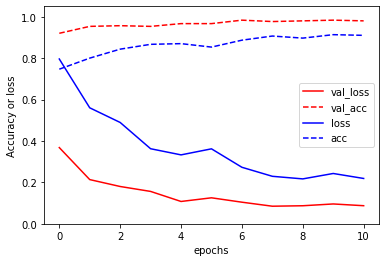

epoch=11: 

100%|██████████| 844/844 [04:53<00:00,  2.87it/s, loss=0.192, val_loss=0.0695, acc=0.92, val_acc=0.99]


epoch=12: 

100%|██████████| 844/844 [04:52<00:00,  2.88it/s, loss=0.168, val_loss=0.0872, acc=0.943, val_acc=0.98]


epoch=13: 

100%|██████████| 844/844 [04:49<00:00,  2.91it/s, loss=0.178, val_loss=0.0768, acc=0.937, val_acc=0.983]


epoch=14: 

100%|██████████| 844/844 [04:44<00:00,  2.97it/s, loss=0.145, val_loss=0.0786, acc=0.957, val_acc=0.987]


epoch=15: 

100%|██████████| 844/844 [04:44<00:00,  2.96it/s, loss=0.142, val_loss=0.0753, acc=0.937, val_acc=0.987]


epoch=16: 

100%|██████████| 844/844 [04:46<00:00,  2.95it/s, loss=0.132, val_loss=0.0695, acc=0.953, val_acc=0.987]


epoch=17: 

100%|██████████| 844/844 [04:41<00:00,  3.00it/s, loss=0.119, val_loss=0.0727, acc=0.977, val_acc=0.997]


epoch=18: 

100%|██████████| 844/844 [04:43<00:00,  2.98it/s, loss=0.142, val_loss=0.081, acc=0.97, val_acc=0.99]


epoch=19: 

100%|██████████| 844/844 [04:44<00:00,  2.96it/s, loss=0.144, val_loss=0.0838, acc=0.95, val_acc=0.99]


epoch=20: 

100%|██████████| 844/844 [04:51<00:00,  2.89it/s, loss=0.129, val_loss=0.0806, acc=0.963, val_acc=0.987]


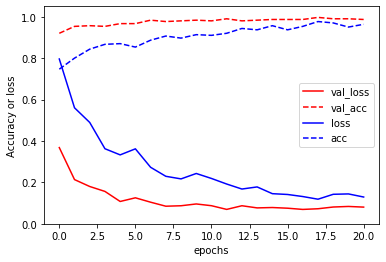

epoch=21: 

100%|██████████| 844/844 [04:52<00:00,  2.89it/s, loss=0.109, val_loss=0.082, acc=0.977, val_acc=0.997]


epoch=22: 

100%|██████████| 844/844 [04:55<00:00,  2.86it/s, loss=0.134, val_loss=0.0875, acc=0.967, val_acc=0.987]


epoch=23: 

100%|██████████| 844/844 [04:55<00:00,  2.86it/s, loss=0.103, val_loss=0.0814, acc=0.973, val_acc=0.993]


epoch=24: 

100%|██████████| 844/844 [04:55<00:00,  2.85it/s, loss=0.107, val_loss=0.0875, acc=0.98, val_acc=0.983]


epoch=25: 

100%|██████████| 844/844 [04:53<00:00,  2.87it/s, loss=0.0998, val_loss=0.0776, acc=0.973, val_acc=0.993]


epoch=26: 

100%|██████████| 844/844 [04:57<00:00,  2.84it/s, loss=0.117, val_loss=0.0953, acc=0.973, val_acc=0.973]


epoch=27: 

100%|██████████| 844/844 [04:51<00:00,  2.89it/s, loss=0.0945, val_loss=0.088, acc=0.973, val_acc=0.987]


epoch=28: 

100%|██████████| 844/844 [04:56<00:00,  2.84it/s, loss=0.119, val_loss=0.0804, acc=0.973, val_acc=0.99]


epoch=29: 

100%|██████████| 844/844 [04:52<00:00,  2.88it/s, loss=0.0875, val_loss=0.0837, acc=0.99, val_acc=0.997]


epoch=30: 

100%|██████████| 844/844 [04:54<00:00,  2.86it/s, loss=0.101, val_loss=0.0822, acc=0.98, val_acc=0.997]


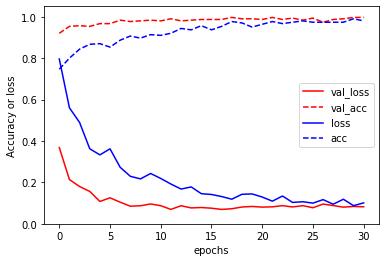

epoch=31: 

100%|██████████| 844/844 [04:53<00:00,  2.87it/s, loss=0.105, val_loss=0.087, acc=0.99, val_acc=0.993]


epoch=32: 

100%|██████████| 844/844 [04:56<00:00,  2.85it/s, loss=0.106, val_loss=0.103, acc=0.98, val_acc=0.987]


epoch=33: 

100%|██████████| 844/844 [05:00<00:00,  2.81it/s, loss=0.0901, val_loss=0.108, acc=0.997, val_acc=0.99]


epoch=34: 

100%|██████████| 844/844 [05:01<00:00,  2.79it/s, loss=0.1, val_loss=0.0982, acc=0.987, val_acc=0.99]


epoch=35: 

100%|██████████| 844/844 [06:16<00:00,  2.24it/s, loss=0.00917, val_loss=0.0232, acc=0.993, val_acc=0.99]


epoch=36: 

100%|██████████| 844/844 [04:58<00:00,  2.83it/s, loss=0.00976, val_loss=0.0237, acc=0.993, val_acc=0.993]


epoch=37: 

100%|██████████| 844/844 [04:57<00:00,  2.84it/s, loss=0.0098, val_loss=0.0237, acc=0.993, val_acc=0.993]


epoch=38: 

100%|██████████| 844/844 [04:59<00:00,  2.82it/s, loss=0.00986, val_loss=0.0238, acc=0.993, val_acc=0.993]


epoch=39: 

100%|██████████| 844/844 [04:55<00:00,  2.86it/s, loss=0.00994, val_loss=0.0239, acc=0.993, val_acc=0.993]


epoch=40: 

100%|██████████| 844/844 [04:54<00:00,  2.87it/s, loss=0.01, val_loss=0.024, acc=0.993, val_acc=0.993]


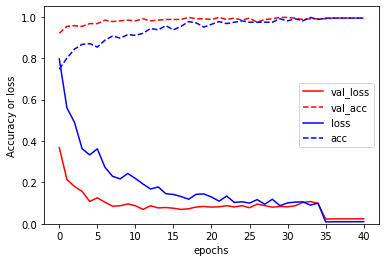

epoch=41: 

100%|██████████| 844/844 [04:57<00:00,  2.83it/s, loss=0.0102, val_loss=0.0241, acc=0.993, val_acc=0.993]


epoch=42: 

100%|██████████| 844/844 [05:02<00:00,  2.79it/s, loss=0.0103, val_loss=0.0242, acc=0.993, val_acc=0.993]


epoch=43: 

100%|██████████| 844/844 [05:01<00:00,  2.80it/s, loss=0.0104, val_loss=0.0244, acc=0.993, val_acc=0.993]


epoch=44: 

100%|██████████| 844/844 [05:02<00:00,  2.79it/s, loss=0.0106, val_loss=0.0246, acc=0.993, val_acc=0.993]


epoch=45: 

100%|██████████| 844/844 [05:09<00:00,  2.73it/s, loss=0.0108, val_loss=0.0248, acc=0.993, val_acc=0.993]


epoch=46: 

100%|██████████| 844/844 [05:10<00:00,  2.72it/s, loss=0.011, val_loss=0.025, acc=0.993, val_acc=0.993]


epoch=47: 

100%|██████████| 844/844 [05:06<00:00,  2.76it/s, loss=0.0113, val_loss=0.0252, acc=0.993, val_acc=0.993]


epoch=48: 

100%|██████████| 844/844 [05:06<00:00,  2.75it/s, loss=0.0115, val_loss=0.0254, acc=0.993, val_acc=0.993]


epoch=49: 

100%|██████████| 844/844 [05:07<00:00,  2.75it/s, loss=0.0118, val_loss=0.0257, acc=0.993, val_acc=0.993]


epoch=50: 

100%|██████████| 844/844 [05:13<00:00,  2.69it/s, loss=0.012, val_loss=0.026, acc=0.993, val_acc=0.993]


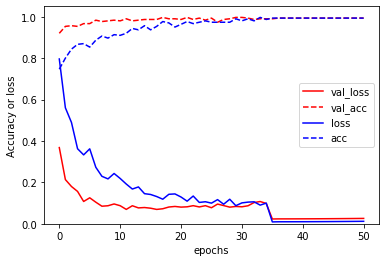

epoch=51: 

100%|██████████| 844/844 [05:06<00:00,  2.75it/s, loss=0.0124, val_loss=0.0263, acc=0.993, val_acc=0.993]


epoch=52: 

100%|██████████| 844/844 [05:13<00:00,  2.70it/s, loss=0.0127, val_loss=0.0266, acc=0.993, val_acc=0.993]


epoch=53: 

100%|██████████| 844/844 [05:10<00:00,  2.72it/s, loss=0.0131, val_loss=0.027, acc=0.993, val_acc=0.993]


epoch=54: 

100%|██████████| 844/844 [05:10<00:00,  2.72it/s, loss=0.0135, val_loss=0.0274, acc=0.993, val_acc=0.993]


epoch=55: 

100%|██████████| 844/844 [05:11<00:00,  2.71it/s, loss=0.0139, val_loss=0.0278, acc=0.993, val_acc=0.993]


epoch=56: 

100%|██████████| 844/844 [05:11<00:00,  2.71it/s, loss=0.0144, val_loss=0.0283, acc=0.993, val_acc=0.993]


epoch=57: 

100%|██████████| 844/844 [05:09<00:00,  2.73it/s, loss=0.0148, val_loss=0.0288, acc=0.993, val_acc=0.993]


epoch=58: 

100%|██████████| 844/844 [05:03<00:00,  2.78it/s, loss=0.0154, val_loss=0.0293, acc=0.993, val_acc=0.993]


epoch=59: 

100%|██████████| 844/844 [05:00<00:00,  2.81it/s, loss=0.0159, val_loss=0.0298, acc=0.993, val_acc=0.993]


epoch=60: 

100%|██████████| 844/844 [05:07<00:00,  2.74it/s, loss=0.0164, val_loss=0.0304, acc=0.993, val_acc=0.993]


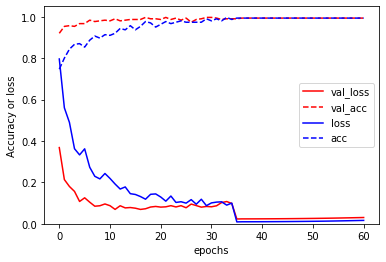

epoch=61: 

100%|██████████| 844/844 [05:07<00:00,  2.74it/s, loss=0.017, val_loss=0.0309, acc=0.993, val_acc=0.993]


epoch=62: 

100%|██████████| 844/844 [05:05<00:00,  2.76it/s, loss=0.0176, val_loss=0.0316, acc=0.993, val_acc=0.993]


epoch=63: 

100%|██████████| 844/844 [05:02<00:00,  2.79it/s, loss=0.0183, val_loss=0.0322, acc=0.993, val_acc=0.993]


epoch=64: 

100%|██████████| 844/844 [05:03<00:00,  2.78it/s, loss=0.0189, val_loss=0.0329, acc=0.993, val_acc=0.993]


epoch=65: 

100%|██████████| 844/844 [05:03<00:00,  2.78it/s, loss=0.0196, val_loss=0.0336, acc=0.993, val_acc=0.993]


epoch=66: 

100%|██████████| 844/844 [05:04<00:00,  2.77it/s, loss=0.0204, val_loss=0.0343, acc=0.993, val_acc=0.993]


epoch=67: 

100%|██████████| 844/844 [05:07<00:00,  2.74it/s, loss=0.0211, val_loss=0.035, acc=0.993, val_acc=0.993]


epoch=68: 

100%|██████████| 844/844 [05:05<00:00,  2.76it/s, loss=0.0218, val_loss=0.0358, acc=0.993, val_acc=0.993]


epoch=69: 

100%|██████████| 844/844 [05:04<00:00,  2.77it/s, loss=0.0226, val_loss=0.0366, acc=0.993, val_acc=0.993]


epoch=70: 

100%|██████████| 844/844 [06:20<00:00,  2.22it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


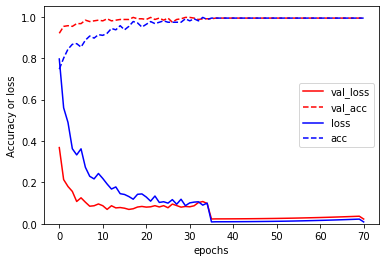

epoch=71: 

100%|██████████| 844/844 [05:03<00:00,  2.78it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=72: 

100%|██████████| 844/844 [05:02<00:00,  2.79it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=73: 

100%|██████████| 844/844 [04:59<00:00,  2.82it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=74: 

100%|██████████| 844/844 [04:58<00:00,  2.83it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=75: 

100%|██████████| 844/844 [04:56<00:00,  2.84it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=76: 

100%|██████████| 844/844 [04:55<00:00,  2.85it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=77: 

100%|██████████| 844/844 [04:57<00:00,  2.84it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=78: 

100%|██████████| 844/844 [04:59<00:00,  2.82it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=79: 

100%|██████████| 844/844 [05:03<00:00,  2.78it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=80: 

100%|██████████| 844/844 [04:54<00:00,  2.87it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


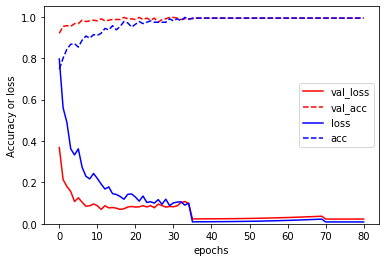

epoch=81: 

100%|██████████| 844/844 [04:52<00:00,  2.89it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=82: 

100%|██████████| 844/844 [04:51<00:00,  2.89it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=83: 

100%|██████████| 844/844 [04:52<00:00,  2.89it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=84: 

100%|██████████| 844/844 [04:52<00:00,  2.89it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=85: 

100%|██████████| 844/844 [04:51<00:00,  2.89it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=86: 

100%|██████████| 844/844 [04:52<00:00,  2.88it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=87: 

100%|██████████| 844/844 [04:54<00:00,  2.87it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=88: 

100%|██████████| 844/844 [04:54<00:00,  2.87it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=89: 

100%|██████████| 844/844 [04:52<00:00,  2.89it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=90: 

100%|██████████| 844/844 [04:50<00:00,  2.90it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


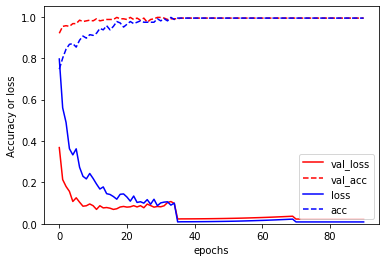

epoch=91: 

100%|██████████| 844/844 [04:51<00:00,  2.89it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=92: 

100%|██████████| 844/844 [04:56<00:00,  2.85it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=93: 

100%|██████████| 844/844 [04:55<00:00,  2.86it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=94: 

100%|██████████| 844/844 [04:55<00:00,  2.85it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=95: 

100%|██████████| 844/844 [04:52<00:00,  2.88it/s, loss=0.00899, val_loss=0.0229, acc=0.993, val_acc=0.993]


epoch=96: 

 36%|███▌      | 305/844 [01:44<03:31,  2.54it/s, loss=0.0363, val_loss=0.00434, acc=0.967, val_acc=0.867]

In [ ]:
epochs = 100
batch_size = 16
fs=42
wdl = 1e-5
num=5
x,t=create_img(X_train,y_train,num)
model = build_model(fs,wdl)
history =  model.fit(model,x,t,epochs,batch_size,X_test,y_test)
test_acc =model.accuracy(X_test,y_test)
print('accuracy={}'.format(test_acc))

In [ ]:
def objective(trial):
    epochs = 30
    batch_size = trial.suggest_int('bs',8,48,step=8)
    fs = trial.suggest_int('fs',8,24,step=4)
    wdl=trial.suggest_loguniform('wdl',5e-5,3e-4)
    dr=trial.suggest_float('dr',0.35,0.55)
    num=6
    print(batch_size)
    print(fs)
    print(wdl)
    print(dr)
  #モデルを作成
    x,t=create_img(X_train,y_train,num)
    model = build_model(fs,wdl,dr)
    history = model.fit(model,x,t,epochs,batch_size,X_test,y_test)
    train_acc =model.accuracy(x,t)
    print('accuracy={}'.format(train_acc))
    # lossとaccuracyのグラフ化
    df_log = pd.DataFrame(history)
    df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
    plt.ylim([0,1.5])
    plt.ylabel("Accuracy or loss")
    plt.xlabel("epochs")
    plt.show()

    #検証用データに対する正答率が最大となるハイパーパラメータを求める
    return history['val_acc'][-1]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [ ]:
    # lossとaccuracyのグラフ化
    df_log = pd.DataFrame(history)
    df_log.plot(style=['r-', 'r--', 'b-', 'b--'])
    plt.ylim([0,4])
    plt.ylabel("Accuracy or loss")
    plt.xlabel("epochs")
    plt.show()

In [ ]:
with open("katakana_model.pickle", "wb") as f:
    pickle.dump(tnet, f)